# CS5785 Final Code

### First we load libraries, define our train/test split, and load the word2vec dictionary using gensim

How to download the pretrained word2vec representation: run in command line `wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"`

In [17]:



import os
import csv
import random
import gensim
import numpy as np

num_train = 8000
num_dev = 2000
num_test = 2000
split_idx = list(range(num_train + num_dev))
random.shuffle(split_idx)
word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
print("Loaded word vectors successfully!")

#from gensim.models import Word2Vec
#word2vec = Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, norm_only=True)

Loaded word vectors successfully!



### Next we parse the descriptions to form the X matrices, along with removing stop words


In [18]:
#Look here for preprocessing stuff and cnn stuff: https://stats.stackexchange.com/questions/335836/cnn-architectures-for-regression
from sklearn.preprocessing import StandardScaler

def parse_descriptions(data_dir, num_doc):
    docs = []
    for i in range(num_doc):
        path = os.path.join(data_dir, "%d.txt" % i)
        with open(path) as f:
            docs.append(f.read())
    return docs

def doc_to_vec(sentence, word2vec):
    # get list of word vectors in sentence
    word_vecs = [word2vec.get_vector(w) for w in sentence.split() if w in word2vec.vocab]
    # return average

    return np.stack(word_vecs).mean(0)

# build x matrices
train_dev_desc = parse_descriptions("descriptions_train", num_doc=(num_train+num_dev))
test_desc = parse_descriptions("descriptions_test", num_doc=num_test)

from nltk.stem import PorterStemmer 
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from gensim import corpora, models, similarities
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pandas as pd
from nltk import word_tokenize, pos_tag


# articles = (shared_articles['text']).tolist()
articles = (train_dev_desc)


stop_words = set( {"is", "A", "his", "her", "them", ".", "!","?",":",",","that","are","am","there","and","it","its","has","have","will","what"}) 
for i in range(len(train_dev_desc)):
    sentence = train_dev_desc[i]
    word_tokens = word_tokenize(sentence) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 

    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    # print(filtered_sentence)
    sentence = ' '.join(word for word in filtered_sentence)
    # print(sentence)


    tagged_sentence = nltk.tag.pos_tag(sentence.split())
    # print(tagged_sentence)
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'IN' and tag != 'DT' and tag != 'TO' and tag != 'RBR'and tag != 'RBS']
    edited_sentence = ' '.join(word for word in edited_sentence)
    train_dev_desc[i] = edited_sentence

for i in range(len(test_desc)):
    sentence = test_desc[i]
    word_tokens = word_tokenize(sentence) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 

    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    # print(filtered_sentence)
    sentence = ' '.join(word for word in filtered_sentence)
    # print(sentence)


    tagged_sentence = nltk.tag.pos_tag(sentence.split())
    # print(tagged_sentence)
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'IN' and tag != 'DT' and tag != 'TO' and tag != 'RBR'and tag != 'RBS']
    edited_sentence = ' '.join(word for word in edited_sentence)
    test_desc[i] = edited_sentence

x_train = np.array([doc_to_vec(train_dev_desc[i], word2vec) for i in split_idx[:num_train]])
x_dev = np.array([doc_to_vec(train_dev_desc[i], word2vec) for i in split_idx[num_train:]])
x_test = np.array([doc_to_vec(d, word2vec) for d in test_desc])


print("Built all x matrices!")
print("x_train shape:", x_train.shape)
print("x_dev shape:", x_dev.shape)
print("x_test shape:", x_test.shape)


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Built all x matrices!
x_train shape: (8000, 300)
x_dev shape: (2000, 300)
x_test shape: (2000, 300)


# Next we parse the files to form the Y matrices, along with concatenating the feature vectores and the tags to create the full Y matrix

In [19]:
def parse_labels(data_dir, num_doc):
    docs = []
    for i in range(num_doc):
        path = os.path.join(data_dir, "%d.txt" % i)
        with open(path,'rb') as f:
            docs.append(f.read())
    return docs


tags_train = parse_labels("aml_final/google_labels", num_doc=(num_train+num_dev))
tags_test = parse_labels("aml_final/google_labels_test", num_doc=num_test)

for i in range(len(tags_train)):
    tags_train[i] = tags_train[i].decode('utf8','ignore').lower()
    if not tags_train[i]:
        tags_train[i] = 'none'

for i in range(len(tags_test)):
    tags_test[i] = tags_test[i].decode('utf8', 'ignore').lower()
    if not tags_test[i]:
        tags_test[i] = 'none'

tags_train[2039] = "kitchen"
tags_train[5216] = 'shirt'
tags_train[9017] = 'person cat'


##################tags official##############
def remove_duplicate_words(s):
    return ' '.join(dict.fromkeys(s.split()))

tags_official_train = parse_descriptions('tags_train', num_doc=num_train + num_dev)
tags_official_test = parse_descriptions('tags_test', num_doc=num_test)

for i in range(len(tags_official_train)):
    tags_official_train[i] = tags_official_train[i].replace(':',' ')
    tags_official_train[i] = tags_official_train[i].replace("\n", " ")
    tags_official_train[i] = remove_duplicate_words(tags_official_train[i])
    tags_train[i] = tags_train[i] + tags_official_train[i]
    
for i in range(len(tags_official_test)):
    tags_official_test[i] = tags_official_test[i].replace(':',' ')
    tags_official_test[i] = tags_official_test[i].replace("\n", " ")
    tags_official_test[i] = remove_duplicate_words(tags_official_test[i])
    tags_test[i] = tags_test[i] + tags_official_test[i]
########################tags
print(tags_test[0])
# for i in range(num_dev): #these are images google couldnt label
#     if not tags_train[i]:
#         tags_train[i] = ' '
#     if not tags_test[i]:
#         tags_test[i] = ' '
        
stop_words = set( {"is", "A", "his", "her", "them", ".", "!","?",":",",","that","are","am","there","and","it","its","has","have","will","what"}) 
for i in range(len(tags_train)):
    sentence = tags_train[i]
    word_tokens = word_tokenize(sentence) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 

    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    # print(filtered_sentence)
    sentence = ' '.join(word for word in filtered_sentence)
    # print(sentence)


    tagged_sentence = nltk.tag.pos_tag(sentence.split())
    # print(tagged_sentence)
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'IN' and tag != 'DT' and tag != 'TO' and tag != 'RBR'and tag != 'RBS']
    edited_sentence = ' '.join(word for word in edited_sentence)
    tags_train[i] = edited_sentence

for i in range(len(tags_test)):
    sentence = tags_test[i]
    word_tokens = word_tokenize(sentence) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 

    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    # print(filtered_sentence)
    sentence = ' '.join(word for word in filtered_sentence)
    # print(sentence)


    tagged_sentence = nltk.tag.pos_tag(sentence.split())
    # print(tagged_sentence)
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'IN' and tag != 'DT' and tag != 'TO' and tag != 'RBR'and tag != 'RBS']
    edited_sentence = ' '.join(word for word in edited_sentence)
    tags_test[i] = edited_sentence

    
x_tr = np.array([doc_to_vec(tags_train[i], word2vec) for i in split_idx[:num_train]])
x_d = np.array([doc_to_vec(tags_train[i], word2vec) for i in split_idx[num_train:]])
x_t = np.array([doc_to_vec(d, word2vec) for d in tags_test])

y_train = np.append(x_tr,x_train,axis=0)
y_dev = np.append(x_d,x_dev,axis=0)
# y_test = np.append(x_t,x_test,axis=0)


x_train = np.append(x_train, x_tr, axis=0)
x_dev = np.append(x_dev, x_d, axis=0)


##Parse Resnet
#############################3
def parse_features(features_path):
    vec_map = {}
    with open(features_path) as f:
        for row in csv.reader(f):
            img_id = int(row[0].split("/")[1].split(".")[0])
            vec_map[img_id] = np.array([float(x) for x in row[1:]])
    return np.array([v for k, v in sorted(vec_map.items())])

# build y matrices
p = np.random.randn(1000, 1000)
y_train_dev = parse_features("features_train/features_resnet1000_train.csv") @ p
y_train2 = y_train_dev[split_idx[:num_train]]
y_dev2 = y_train_dev[split_idx[num_train:]]
y_test = parse_features("features_test/features_resnet1000_test.csv") @ p

y_train2 =  np.append(y_train2, y_train2, axis=0)
y_dev2 =  np.append(y_dev2, y_dev2, axis=0)

##Append the tags and the features
y_train = np.append(y_train2, y_train, axis=1)
y_dev = np.append(y_dev2, y_dev, axis=1)
y_test = np.append(y_test, x_t, axis=1)

##Add in the additional higher level resnet features
y_train_dev2 = parse_features("features_train/features_resnet1000intermediate_train.csv")
y_train3 = y_train_dev2[split_idx[:num_train]]
y_dev3 = y_train_dev2[split_idx[num_train:]]
y_test2 = parse_features("features_test/features_resnet1000intermediate_test.csv")

y_train3 =  np.append(y_train3, y_train3, axis=0)
y_dev3 =  np.append(y_dev3, y_dev3, axis=0)


##Append the old features and the new features
y_train = np.append(y_train,y_train3, axis=1)
y_dev = np.append(y_dev,y_dev3, axis=1)
y_test = np.append(y_test, y_test2, axis=1)


##############





scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_dev  = scaler.fit_transform(x_dev)
x_test  = scaler.fit_transform(x_test)


scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_dev  = scaler.fit_transform(y_dev)
y_test  = scaler.fit_transform(y_test)
   

print("Built all x matrices!")
print("x_train shape:", x_train.shape)
print("x_dev shape:", x_dev.shape)
print("x_test shape:", x_test.shape)

print("Built all y matrices!")
print("y_train shape:", y_train.shape)
print("y_dev shape:", y_dev.shape)
print("y_test shape:", y_test.shape)




room bed furniture property bedroom bunk bed house building interior design hostel furniture bed accessory backpack suitcase tie
Built all x matrices!
x_train shape: (16000, 300)
x_dev shape: (4000, 300)
x_test shape: (2000, 300)
Built all y matrices!
y_train shape: (16000, 3348)
y_dev shape: (4000, 3348)
y_test shape: (2000, 3348)



### In addition we parse the ResNet features to form the Y matrices


# Build CNN below

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import layers
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D




def lenet_model():
    model = Sequential()
    model.add(layers.Dense(6696, input_shape=(300,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3348, activation = 'linear'))
    model.compile(Adam(lr = .01), loss = 'mse')
    return model

model = lenet_model()
print(model.summary())

model.fit(x_train,y_train, epochs = 150, validation_data = (x_dev,y_dev), shuffle = 1, batch_size = 5000, verbose = 1)


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 6696)              2015496   
_________________________________________________________________
dropout_16 (Dropout)         (None, 6696)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 3348)              22421556  
Total params: 24,437,052
Trainable params: 24,437,052
Non-trainable params: 0
_________________________________________________________________
None
Train on 16000 samples, validate on 4000 samples
Epoch 1/150
16000/16000 [==============================] - 12s 733us/step - loss: 19.0296 - val_loss: 15.5133
Epoch 2/150
16000/16000 [==============================] - 11s 703us/step - loss: 12.5549 - val_loss: 8.3823
Epoch 3/150
16000/16000 [==============================] - 11s 705us/step - loss: 6.8996 - val_los

# Show performance

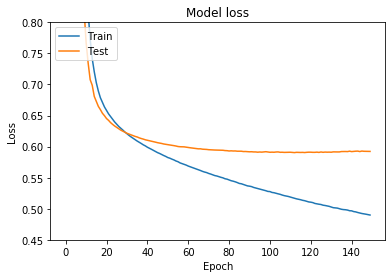

In [36]:
import matplotlib.pyplot as plt




# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(.45, .8)
plt.show()


### Test the NN model on our development data, computing its MAP@20 with cosine distance, and investigating the quality of the rankings


In [33]:
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import pairwise_distances

from scipy.spatial.distance import cdist
from scipy.spatial.distance import minkowski
from scipy.spatial.distance import cosine
from scipy import spatial

from sklearn.metrics.pairwise import cosine_similarity


from scipy.spatial import distance


def dist_matrix(x1, x2):
    return ((np.expand_dims(x1, 1) - np.expand_dims(x2, 0)) ** 2).sum(2) ** 0.5

def get_dif(Di,Ti):
    return spatial.distance.cosine(Di, Ti)


##NN
y_dev_pred = model.predict(x_dev)


ranks = []
for i in range(2000):
    print(i, end="-")
    tmp = np.zeros(2000)
    for j in range(2000):
        tmp[j] = get_dif(y_dev_pred[i], y_dev[j])
        
#     i_sorted = np.argsort(tmp)[::-1]
    ranks.append(tmp)

dev_distances = ranks


dev_scores = []
dev_pos_list = []

for i in range(num_dev):
    pred_dist_idx = list(np.argsort(dev_distances[i]))
    dev_pos = pred_dist_idx.index(i)
    dev_pos_list.append(dev_pos)
    if dev_pos < 20:
        dev_scores.append(1 / (dev_pos + 1))
    else:
        dev_scores.append(0.0)

print("Development MAP@20:", np.mean(dev_scores))
print("Mean index of true image", np.mean(dev_pos_list))
print("Median index of true image", np.median(dev_pos_list))
print("Shape: ", y_dev_pred.shape)
print("Shape: ", y_dev.shape)

0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-110-111-112-113-114-115-116-117-118-119-120-121-122-123-124-125-126-127-128-129-130-131-132-133-134-135-136-137-138-139-140-141-142-143-144-145-146-147-148-149-150-151-152-153-154-155-156-157-158-159-160-161-162-163-164-165-166-167-168-169-170-171-172-173-174-175-176-177-178-179-180-181-182-183-184-185-186-187-188-189-190-191-192-193-194-195-196-197-198-199-200-201-202-203-204-205-206-207-208-209-210-211-212-213-214-215-216-217-218-219-220-221-222-223-224-225-226-227-228-229-230-231-232-233-234-235-236-237-238-239-240-241-242-243-244-245-246-247-248-249-250-251-252-253-254-255-256-257-258-259-260-261-262-263-264-265-266-267-268-269-270-271-272-273-274-275-276-27

In [7]:
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import pairwise_distances

from scipy.spatial.distance import cdist
from scipy.spatial.distance import minkowski
from scipy.spatial.distance import cosine
from scipy import spatial

from sklearn.metrics.pairwise import cosine_similarity


from scipy.spatial import distance

def get_dif(Di,Ti):
    return spatial.distance.cosine(Di, Ti)


### Finally we use our model to compute top-20 predictions on the test data that can be submitted to Kaggle


In [34]:
# create test predictions
x_train_all = np.concatenate([x_train, x_dev])
y_train_all = np.concatenate([y_train, y_dev])
# reg_best.fit(x_train_all, y_train_all)

def lenet_model2():
    model = Sequential()
    model.add(layers.Dense(6696, input_shape=(300,), activation='relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(3348, activation = 'linear'))
#     opt = SGD(lr=0.01, momentum=0.9)
    model.compile(Adam(lr = .01), loss = 'mse')
    return model

model = lenet_model2()
print(model.summary())


model.fit(x_train_all,y_train_all, epochs = 200, shuffle = 1, batch_size = 5000, verbose = 1)


# y_test_pred = reg_best.predict(x_test)
y_test_pred = model.predict(x_test)

ranks = []
for i in range(2000):
    print(i)
    tmp = np.zeros(2000)
    for j in range(2000):
        tmp[j] = get_dif(y_test_pred[i], y_test[j])
        
#     i_sorted = np.argsort(tmp)[::-1]
    ranks.append(tmp)
    
# test_distances = dist_matrix(y_test_pred, y_test)
test_distances = ranks
pred_rows = []


for i in range(num_test):
    test_dist_idx = list(np.argsort(test_distances[i]))
    top_20 = test_dist_idx[:20]
    row = ["%d.jpg" % i for i in test_dist_idx[:20]]
    pred_rows.append(" ".join(row))

with open("test_submission_NN_AllFeatures.csv", "w") as f:
    f.write("Descritpion_ID,Top_20_Image_IDs\n")
    for i, row in enumerate(pred_rows):
        f.write("%d.txt,%s\n" % (i, row))

print("Output written!")

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 6696)              2015496   
_________________________________________________________________
dropout_15 (Dropout)         (None, 6696)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 3348)              22421556  
Total params: 24,437,052
Trainable params: 24,437,052
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
20000/20000 [==============================] - 13s 655us/step - loss: 25.6735
Epoch 2/200
20000/20000 [==============================] - 13s 638us/step - loss: 12.4426
Epoch 3/200
20000/20000 [==============================] - 13s 642us/step - loss: 5.8128
Epoch 4/200
20000/20000 [==============================] - 13s 641us/step - loss: 3.3843
Epoch 5/